In [39]:
using DelimitedFiles
# using Statistics
using DataFrames
using CSV
using Printf
using DataStructures
using Base.Threads
using ProgressMeter
using NPZ
using MMCAcovid19
using ArgParse
using JSON
using Dates

In [2]:
## -----------------------------------------------------------------------------
## LOADING DATA
## -----------------------------------------------------------------------------

data_path = "../data/"
instance_path = "../data/"

# Config file
config = JSON.parsefile(joinpath(data_path, "config.json"))

Dict{String,Any} with 21 entries:
  "parameters_columns"      => Any["P", "beta", "scale_beta", "t_inc", "scale_e…
  "weights"                 => "ones"
  "window_mean_size"        => 14
  "data"                    => Dict{String,Any}("sim_data_filename"=>"deaths_ne…
  "summarize"               => Dict{String,Any}("seeds_columns"=>Any["1573", "3…
  "epi_param_columns"       => Any["P", "beta", "scale_beta", "t_inc", "scale_e…
  "seed_patches_idx"        => Any["2309", "2825", "1929", "314", "2141", "2193…
  "seeds"                   => Any[Dict{String,Any}("patch_id"=>"4109101","patc…
  "top_n_trajectories_ci"   => 500
  "last_day_train"          => "2021-02-09"
  "window_mean_real_data"   => true
  "metric"                  => "RMSE"
  "A0_filename"             => "A0_initial_conditions.csv"
  "first_day_train"         => "2020-02-09"
  "last_day_simulation"     => "2021-02-09"
  "first_day_simulation"    => "2020-02-09"
  "daily_mobility_matrices" => "daily_mobility_matrices_experime

In [3]:
# Parameters to simulate
paramsDF = CSV.read(joinpath(instance_path, "params.csv"), DataFrame)

# Output simulation
output_path = joinpath(instance_path, "output")

# Loading mobility network
network = CSV.read(joinpath(data_path, "R_mobility_matrix.csv"), DataFrame)
edgelist = convert(Array{Int64, 2}, network[:, 1:2])
Rᵢⱼ = copy(network[:, 3])

# Patch surface
sᵢ = CSV.read(joinpath(data_path, "S_patch_surface_area.csv"), DataFrame)[:,"area"]

# Population info
nᵢ_ages = CSV.read(@sprintf("%s/n_population_patch_age.csv", data_path), DataFrame);
A0_instance_filename = @sprintf("%s/%s", instance_path, config["A0_filename"])
A0_data_filename = @sprintf("%s/%s", data_path, config["A0_filename"])
if isfile(A0_instance_filename)
  println("Loading A0 from instance/ folder")
  conditions₀ = CSV.read(A0_instance_filename, DataFrame)
else
  println("Loading A0 from data/ folder")
  conditions₀ = CSV.read(A0_data_filename, DataFrame)
end

C = readdlm(@sprintf("%s/C_age_contact_matrix.csv", data_path),
            ',', Float64)

# Containement measures
κ₀_df = CSV.read(@sprintf("%s/%s", data_path, config["kappa0_filename"]), DataFrame)

# Patch to CCAA mapping matrix
PatchToCCAA = npzread(@sprintf("%s/patch_to_ccaa.npy", data_path))
n_ccaa = size(PatchToCCAA)[1]
n_patches = size(PatchToCCAA)[2]


## -----------------------------------------------------------------------------
## SETTING PARAMETERS (some of them are just placeholders for the values on DF)
## -----------------------------------------------------------------------------


## POPULATION

# Patch population for each strata
nᵢᵍ = copy(transpose(convert(Array{Float64,2}, nᵢ_ages[:,["Y", "M", "O"]])))

# Total patch population
nᵢ = convert(Array{Float64,1}, nᵢ_ages[:,"Total"])

# Num. of patches
M = length(nᵢ)

# Num of stratas
G = size(C)[1]

# Average number of contacts per strata
kᵍ = [11.8, 13.3, 6.76]

# Average number of contacts at home per strata
kᵍ_h = [3.15, 3.17, 3.28]

# Average number of contacts at work per strata
kᵍ_w = [1.72, 5.18, 0.0]

# Degree of mobility per strata
pᵍ = [0.0, 1.0, 0.00]

# Density factor
ξ = 0.01

# Average household size
σ = 2.5

# Check network structure and self-loop correction
edgelist, Rᵢⱼ = MMCAcovid19.correct_self_loops(edgelist, Rᵢⱼ, M)


# population_params = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)


## EPIDEMIC PARAMETERS

# Scaling of the asymptomatic infectivity
scale_β = 0.51

# Infectivity of Symptomatic
βᴵ = 0.0903

# Infectivity of Asymptomatic
βᴬ = scale_β * βᴵ

# Exposed rate
ηᵍ = [1/3.64, 1/3.64, 1/3.64]

# Asymptomatic rate
αᵍ = [1/3.76, 1/1.56, 1/1.56]

# Infectious rate
μᵍ = [1/1.0, 1/3.2, 1/3.2]

# Direct death probability
θᵍ = [0.00, 0.008, 0.047]

# Direct death probability
γᵍ = [0.0003, 0.003, 0.026]

# Pre-deceased rate
ζᵍ = [1/7.8, 1/7.8, 1/7.8]

# Pre-hospitalized in ICU rate
λᵍ = ones(Float64, 3)

# Fatality probability in ICU
ωᵍ = [0.30, 0.30, 0.30]

# Death rate in ICU
ψᵍ = [1/7.0, 1/7.0, 1/7.0]

# ICU discharge rate
χᵍ = [1/21.0, 1/21.0, 1/21.0]

# Number of timesteps
# dia inicial: 9 Feb
# dia final: 14 Abril (66 dias)
# T = 123
# T = 66
first_day = Date(config["first_day_simulation"])
last_day = Date(config["last_day_simulation"])
T = (last_day - first_day).value + 1

# Epidemic parameters
# epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

## CONFINEMENT MEASURES

# Timesteps when the containment measures will be applied
tᶜs = κ₀_df.time[:]

# Array of level of confinement
κ₀s = κ₀_df.reduction[:]

# Array of premeabilities of confined households
ϕs = ones(Float64, length(tᶜs))

# Array of social distancing measures
δs = ones(Float64, length(tᶜs))


## INITIALIZATION OF THE EPIDEMICS

# Initial number of exposed individuals
E₀ = zeros(G, M)

# Initial number of infectious asymptomatic individuals
A₀ = zeros(Float64, G, M)

# Distribution of the intial infected individuals per strata
# WARN: ni idea de por que es necesario el .+ 1 aqui (las semillas ya vienen indexadas partiendo de 1) pero si no lo pongo la simulacion simplemente no funciona
A₀[1, Int.(conditions₀[:,"idx"])] .= 0.12 .* conditions₀[:,"seed"]
A₀[2, Int.(conditions₀[:,"idx"])] .= 0.16 .* conditions₀[:,"seed"]
A₀[3, Int.(conditions₀[:,"idx"])] .= 0.72 .* conditions₀[:,"seed"]

# Initial number of infectious symptomatic individuals
I₀ = zeros(Float64, G, M)

Loading A0 from instance/ folder


3×2850 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [4]:
epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
pop_params = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)

Population_Params(3, 2850, [8914.0, 10503.0, 6400.0, 7659.0, 17601.0, 7836.0, 4121.0, 5216.0, 4398.0, 36410.0  …  21264.0, 9993.0, 12738.0, 5635.0, 5181.0, 9006.0, 15629.0, 5359.0, 13556.0, 30209.0], [1065.0 2470.0 … 564.0 1258.0; 4747.0 5916.0 … 8050.0 17937.0; 3102.0 2117.0 … 4942.0 11014.0], [8385.639864285156, 9491.531014369657, 4994.726422350578, 7585.26721691678, 15401.274139056262, 7379.526507390489, 4883.781047611979, 3890.7405900005215, 6354.175299764222, 37019.64596291311  …  19888.15681269391, 8179.393160300931, 13573.125716159739, 4490.041488204281, 6487.528289015961, 9390.123823499345, 11321.68034656201, 8395.97084372971, 14235.71216695543, 30232.744907052936], [1065.0 2470.0 … 564.0 1258.0; 4218.639864285155 4904.531014369657 … 8729.71216695543 17960.744907052936; 3102.0 2117.0 … 4942.0 11014.0], 46378115, [8885803, 25081895, 12410417], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [1 1; 1 3; … ; 2701 2701; 2815 2815], [0.15384793162874416, 0.002993247160170764, 0.01013232372521305, 

In [5]:

## -----------------------------------------------------------------------------
## SETTING UP SIMULATION VARIABLES
## -----------------------------------------------------------------------------

# Num. of set of epidemic parameters
num_params = length(paramsDF.id)
# num_params = 3

println("Allocating output matrices (size = n_ccaa x T x num_params)")
println("n_patches: ", n_patches)
println("n_ccaa: ", n_ccaa)
println("T: ", T)
println("num_params: ", num_params)

# Arrays where the output variables will be stored
incidence  = zeros(Float64, n_ccaa, T - 1, num_params)
prevalence = zeros(Float64, n_ccaa, T, num_params)
deaths = zeros(Float64, n_ccaa, T, num_params)
deaths_new = zeros(Float64, n_ccaa, T - 1, num_params)

# Populate the circular deque
for t in 1:nThreads
    push!(populations, Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ))
    push!(epi_params, Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T))
end


Allocating output matrices (size = n_ccaa x T x num_params)
n_patches: 2850
n_ccaa: 19
T: 367
num_params: 1000


UndefVarError: UndefVarError: nThreads not defined

In [6]:
## -----------------------------------------------------------------------------
## FUNCTIONS
## -----------------------------------------------------------------------------

"""
    run_simu_params!(epi_params::Epidemic_Params,
                     population::Population_Params,
                     paramsdf::dataframe,
                     indx_id::int64,
                     a₀::array{float64, 2},
                     i₀::array{float64, 2},
                     incidence::array{float64, 2},
                     prevalence::array{float64, 2},
                     deaths_new::array{float64, 2},
                     deaths::array{float64, 2})

Runs a SEAIRHD simulation on a specific set of parameters stored in the DF
updateing the tables of prevalence, incidence, num. of deaths and daily deaths.
"""
function run_simu_params!(epi_params::Epidemic_Params,
                          population::Population_Params,
                          paramsDF::DataFrame,
                          indx_id::Int64,
                          A₀::Array{Float64, 2},
                          I₀::Array{Float64, 2},
                          incidence::Array{Float64, 3},
                          prevalence::Array{Float64, 3},
                          deaths_new::Array{Float64, 3},
                          deaths::Array{Float64, 3})

    # Loading parameters from DF
    id, P, β, scale_β, τ_inc, scale_ea, τᵢ, δ, ϕ, scale₀ = paramsDF[indx_id, :]

    # Set epidemic params to the ones speficied on the DF
    epi_params.βᴬ .= scale_β * β
    epi_params.βᴵ .= β
    epi_params.ηᵍ .= 1.0/(τ_inc * (1.0 - scale_ea))
    epi_params.αᵍ .= [1.0/(τᵢ - 1 + τ_inc * scale_ea),
                      1.0/(τ_inc * scale_ea),
                      1.0/(τ_inc * scale_ea)]
    epi_params.μᵍ .= [1.0, 1.0/τᵢ, 1.0/τᵢ]

    # Reset compartments
    reset_params!(epi_params, population)
    set_initial_infected!(epi_params, population, E₀, scale₀ .* A₀, I₀)

    # Set containment parameters
    ϕs .= ϕ
    δs .= δ

    ## RUN EPIDEMIC SPREADING
    run_epidemic_spreading_mmca!(epi_params, population, tᶜs, κ₀s, ϕs, δs, verbose=false)

    # Compute the prevalence
    prevalence[:, :, indx_id] = PatchToCCAA * sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                   epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                  population.nᵢᵍ, dims = (1))[1,:,:]  # sum by CCAA

    # Compute the incidence
    incidence[:, :, indx_id]  = diff(prevalence[:, :, indx_id], dims=2)

    # Compute total number of deaths
    deaths[:, :, indx_id] = PatchToCCAA * sum(epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .*
                                          population.nᵢᵍ, dims = (1))[1,:,:]  # sum by CCAA

    # Compute daily new deaths
    deaths_new[:, :, indx_id] = diff(deaths[:, :, indx_id], dims=2)

end

run_simu_params!

In [7]:
# ## -----------------------------------------------------------------------------
# ## RUN THE SIMULATION
# ## -----------------------------------------------------------------------------

# # Run the simulation for all the parameters
# for indx_id in 1:num_params
#     println(indx_id)
    
#     pop_params = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
#     epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
    
#     # Run simu
#     run_simu_params!(epi_params,
#                      pop_params,
#                      paramsDF,
#                      indx_id,
#                      A₀,
#                      I₀,
#                      incidence,
#                      prevalence,
#                      deaths_new,
#                      deaths)
# end

In [8]:
pop_params = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
indx_id = 1

# Run simu
run_simu_params!(epi_params,
                 pop_params,
                 paramsDF,
                 indx_id,
                 A₀,
                 I₀,
                 incidence,
                 prevalence,
                 deaths_new,
                 deaths)

19×366 Array{Float64,2}:
 0.0  0.0  0.00518693   0.00891568   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.00345795   0.00594378      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.000864488  0.00148595      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.000864488  0.00148595      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.000864488  0.00148595      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.000864488  0.00148595   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0172898    0.0297189       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0129673    0.0222892       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0172898    0.0297189       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.00691591   0.0118876       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.00345795   0.00594378   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.00172898   0.00297189      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0432244    0.0742973       0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.

In [9]:
epi_params.ρᴵᵍ

3×2850×367 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.09664e-5  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.03548e-6  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     7.59013e-6  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  7.03378e-6  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     6.96241e-7  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     5.1035e-6   0.0  0.0  0.0  0.0  0.0

...

[:, :, 365] =
 4.83259e-48  5.308e-49    4.53685e-49  …  7.58144e-50  7.58142e-50
 7.5611e-48   1.33259e-48  8.72314e-49     1.33271e-49  1.33272e-49
 2.35484e-48  2.50886e-49  1.58923e-49     2.56252e-50  2.56252e-50

[:, :, 366] =
 3.0996e-4

In [10]:
epi_params.ρᴬᵍ

3×2850×367 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  3.05806e-5  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.84902e-6  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.08835e-5  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.96142e-5  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.81354e-6  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.32934e-5  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 6.21969e-8  0.0         0.0         …  1.29679e-8  1.72432e-8  1.57642e-8
 1.37951e-6  1.33221e-7  1.34017e-7     1.12233e-7  3.4322e-7   2.48748e-7
 5.28182e-8  0.0         0.0            1.10125e-8  1.46431e-8  1.33871e-8

...

[:, :, 365] =
 8.64345e-48  9.49374e-49  8.11449e-49  …  1.356e-49    1.35599e-49
 1.2497e-47   2.2025e-48   1.44176e-48     2.20271e-49  2.20272e-49
 3.89208e-48  4.14666e-49  2.62669e-49     4.23535e-50  4.23534e-50

[:, :, 366] =
 5.54386e-48  6.089

In [11]:
# import Pkg
# Pkg.add("Plots")
# Pkg.add("PyPlot")
# Pkg.add("StatsPlots")
# Pkg.add("GraphRecipes")

In [25]:
using Plots

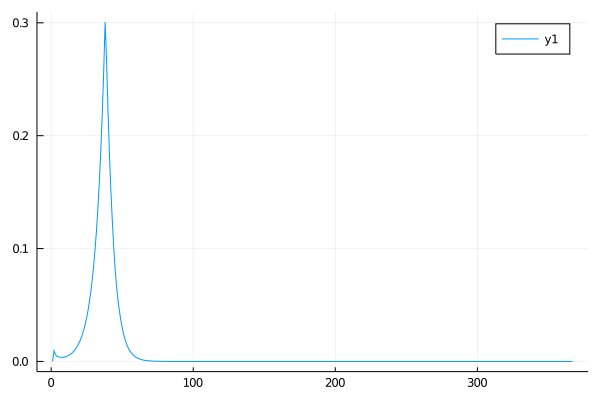

In [13]:
plot(sum(epi_params.ρᴵᵍ, dims=(1,2))[1,1,:])

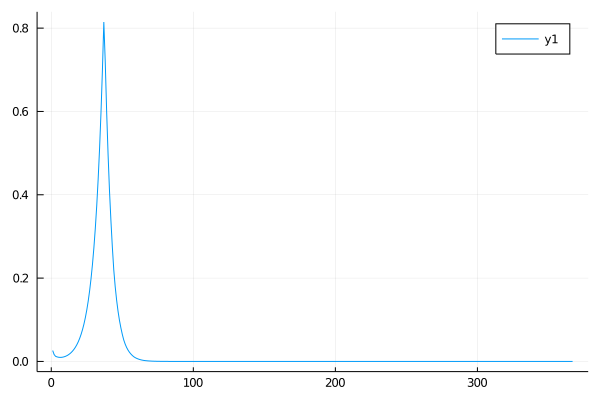

In [26]:
plot(sum(epi_params.ρᴬᵍ, dims=(1,2))[1,1,:])

In [29]:
A = sum(epi_params.ρᴬᵍ, dims=(1,2))[1,1,1:204]
I = sum(epi_params.ρᴵᵍ, dims=(1,2))[1,1,1:204]
E = sum(epi_params.ρᴱᵍ, dims=(1,2))[1,1,1:204]
HD = sum(epi_params.ρᴴᴰᵍ, dims=(1,2))[1,1,1:204]
HR = sum(epi_params.ρᴴᴿᵍ, dims=(1,2))[1,1,1:204]
PH = sum(epi_params.ρᴾᴴᵍ, dims=(1,2))[1,1,1:204]
PD = sum(epi_params.ρᴾᴰᵍ, dims=(1,2))[1,1,1:204]
D = sum(epi_params.ρᴰᵍ, dims=(1,2))[1,1,1:204]
R = sum(epi_params.ρᴿᵍ, dims=(1,2))[1,1,1:204]


204-element Array{Float64,1}:
 0.0
 0.0
 0.008622249992213012
 0.014389507356386713
 0.01867892840397461
 0.022494083532853103
 0.026023425805611403
 0.029418434470921042
 0.03284880979507958
 0.03645022539111646
 0.040348398023298024
 0.044674602271767186
 0.04956652452033905
 ⋮
 3.4434384433479126
 3.443438920232694
 3.443439374408584
 3.4434398069569663
 3.4434402189077318
 3.4434406112417277
 3.443440984893087
 3.443441340751461
 3.443441679664147
 3.4434420024380916
 3.4434423098418105
 3.443442602607228

In [16]:
kappa0 = vcat(zeros(35)./10, κ₀s)[1:204]

204-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.3434300080292504
 0.33998592186877563
 0.3734311160931423
 0.4096178377287831
 0.34558578658127675
 0.3434074528986175
 0.34387907454329386
 0.3414242607151005
 0.3358934579079132
 0.3791184903696208
 0.4118777861981021
 0.3385167528373853

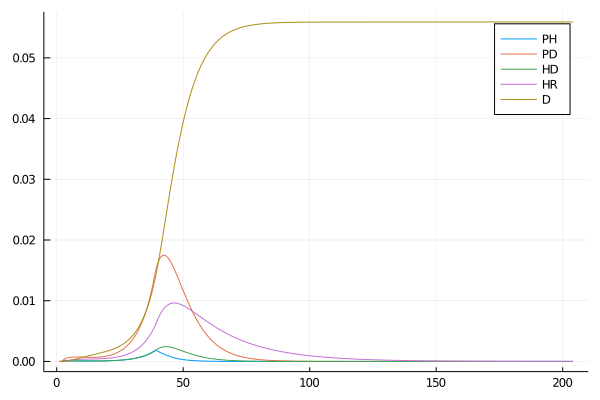

In [17]:
plot([PH, PD, HD, HR, D], label=["PH" "PD" "HD" "HR" "D"])

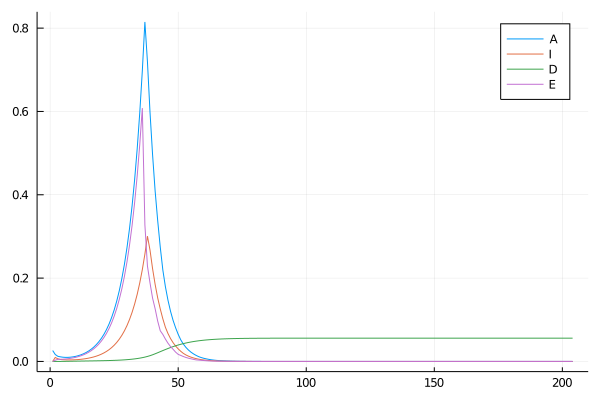

In [18]:
plot([A, I, D, E], label=["A" "I" "D" "E"])


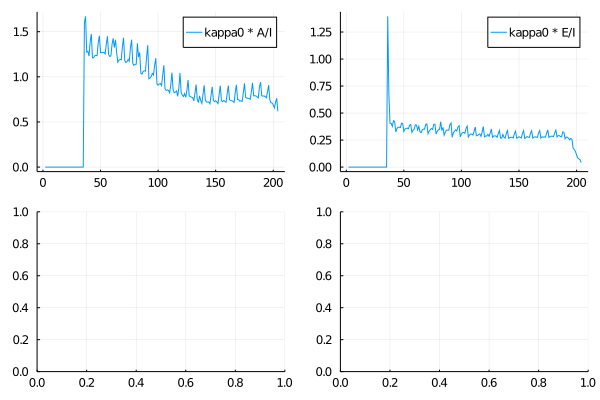

In [19]:
plot([(A./I).*kappa0 (E./I).*kappa0], label=["kappa0 * A/I" "kappa0 * E/I"], layout=(2,2))

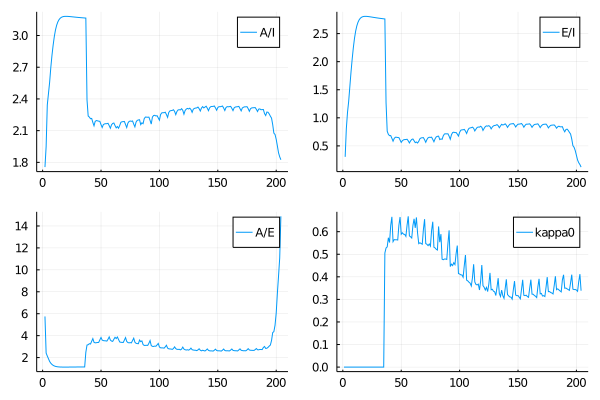

In [27]:
plot([A./I E./I A./E kappa0], label=["A/I" "E/I" "A/E" "kappa0"], layout=(2, 2))

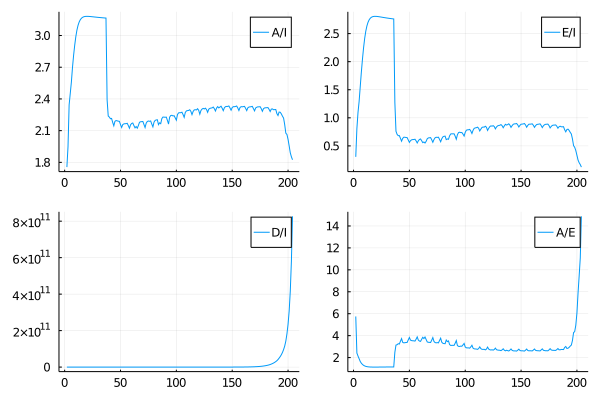

In [21]:
plot([A./I E./I D./I A./E], label=["A/I" "E/I" "D/I" "A/E"], layout=(2, 2))

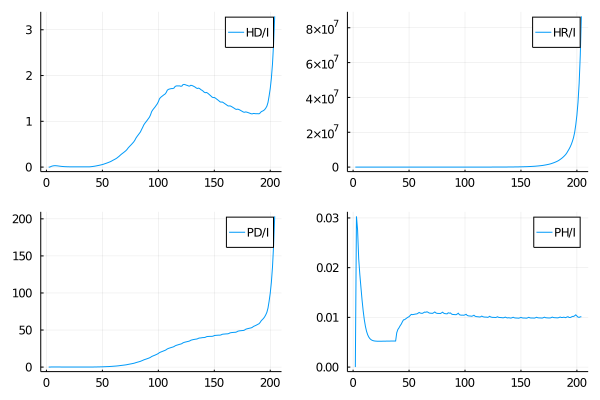

In [22]:
plot([HD./I HR./I PD./I PH./I], label=["HD/I" "HR/I" "PD/I" "PH/I"], layout=(2,2))

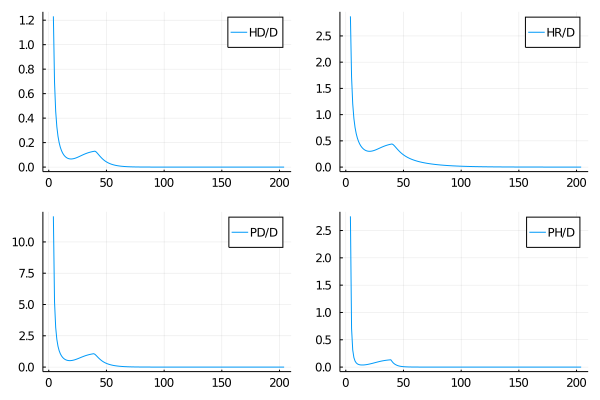

In [23]:
plot([HD./D HR./D PD./D PH./D], label=["HD/D" "HR/D" "PD/D" "PH/D"], layout=(2,2))

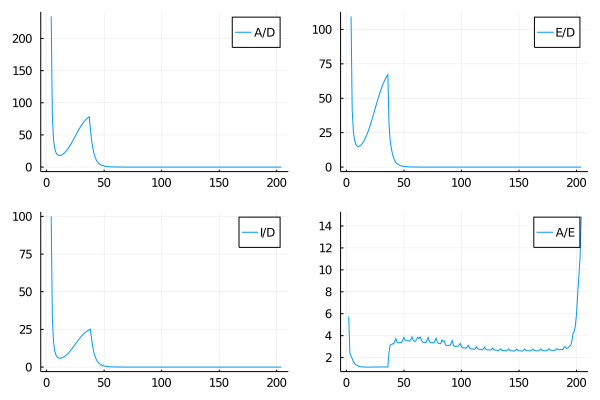

In [24]:
plot([A./D E./D I./D A./E], label=["A/D" "E/D" "I/D" "A/E"], layout=(2, 2))

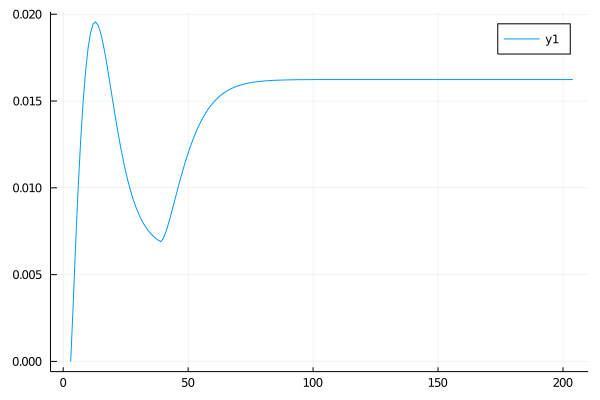

In [30]:
plot(D./R)

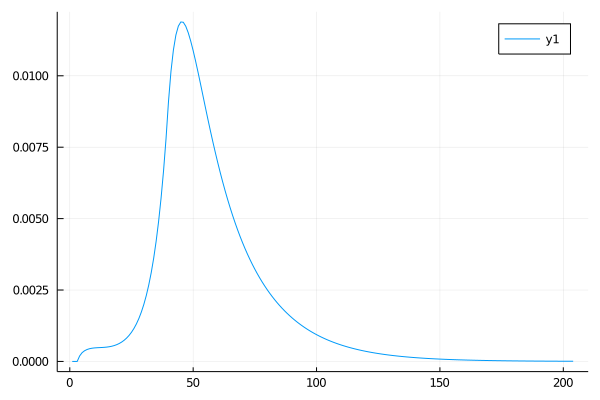

In [38]:
plot(HR+HD)